In [69]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Download latest version
path = kagglehub.dataset_download("adilshamim8/student-depression-dataset")

print("Path to dataset files:", path)

data = pd.read_csv(path + "/student_depression_dataset.csv")

Path to dataset files: /home/nacho/.cache/kagglehub/datasets/adilshamim8/student-depression-dataset/versions/1


# Motivación
La presencia de la salud mental en las discusiones en contextos académicos ha ido al alza en los últimos años. Esto muestra una problemática que plantea desafíos nuevos en los que se requiere evaluar la situación antes de pensar en el diseño, planificación e implementación de los eventuales planes que busquen solucionar dichos problemas.

A modo global, la Organización Mundial de la Salud atribuye al suicidio la tercera causa de muerte en personas entre 15 y 19 años. Acá en Chile, según  la X Encuesta Nacional de Juventudes, la prevalencia de síntomas depresivos y ansiosos es 26,9%. Es decir, uno de cada cuatro estudiantes presenta síntomas de este tipo.

El presente trabajo tomará una muestra de estudiantes de diversas carreras provenientes de la India, y tiene como objetivo trabajar preguntas en las que se busquen correlaciones entre hábitos, carreras, edades, y otros aspectos.

# Exploración y limpieza de datos
El plan de acción para esta etapa consistió en:
+ Analizar las columnas y determinar en primera instancia cuales no serán útiles o se escapan del problema.
+ Para cada una de las columnas restantes, identificar instancias no representativas (o bien, poco representadas) para luego omitirlas.
+ Visualizar los datos, buscando patrones de interés: frecuencias, modas, porcentajes, etc.

## Columnas dropeables

Dentro del estudio se omitirán algunos atributos del dataset que se estiman redundantes o poco útiles en principio. Estas serán:

- *id*: Es indexación redundante respecto al dataframe y no otorga información útil a los modelos de predicción.
- *job satisfaction*: No describe bien el dataset, ya que casi todos los valores son 0.
- *Profession*: Casi todas las instancias son 'student', así que consideraremos las instancias con este atributo y luego se dropea la columna.
- *Work Pressure*: Todas las instancias con atributo Profession igual a student tienen valor 0 en este atributo, luego la variable es irrelevante.

In [70]:
# Primero vemos si hay datos nulos en el dataset
print("Nulos en el dataset:")
data.isna().sum()

Nulos en el dataset:


id                                       0
Gender                                   0
Age                                      0
City                                     0
Profession                               0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         0
Family History of Mental Illness         0
Depression                               0
dtype: int64

Ninguna columna presenta valores nulos. Ahora verificamos estadísticamente para dropear las columnas.

### Job Satisfaction

In [71]:
data['Job Satisfaction'].value_counts()

Job Satisfaction
0.0    27893
2.0        3
4.0        2
1.0        2
3.0        1
Name: count, dtype: int64

Como se ve, casi todas las instancias tienen el mismo valor, la variable no es relevante o de utilidad.

In [72]:
data.drop(columns='Job Satisfaction', inplace=True)

### Profession

In [73]:
data['Profession'].value_counts()

Profession
Student                     27870
Architect                       8
Teacher                         6
'Digital Marketer'              3
Chef                            2
'Content Writer'                2
Pharmacist                      2
Doctor                          2
'UX/UI Designer'                1
'Civil Engineer'                1
Manager                         1
'Educational Consultant'        1
Lawyer                          1
Entrepreneur                    1
Name: count, dtype: int64

Buscamos analizar solo estudiantes, y al ser pocas las otras instancias con valores diferentes en este atributo, podemos eliminar estas instancias y luego al solo tener estudiantes podemos dropear la columna.

In [74]:
data = data[data['Profession'] == 'Student']
data.drop(columns='Profession', inplace=True)

### id y Work Pressure

Por lo mencionado anteriormente solo dropeamos las columnas.

In [75]:
data.drop(columns='id', inplace=True)
data.drop(columns='Work Pressure', inplace=True)

## Limpieza y preprocesamiento de datos

Ahora verificamos las instancias para los atributos restantes.

### Gender

In [76]:
data['Gender'].value_counts().sort_index()

Gender
Female    12341
Male      15529
Name: count, dtype: int64

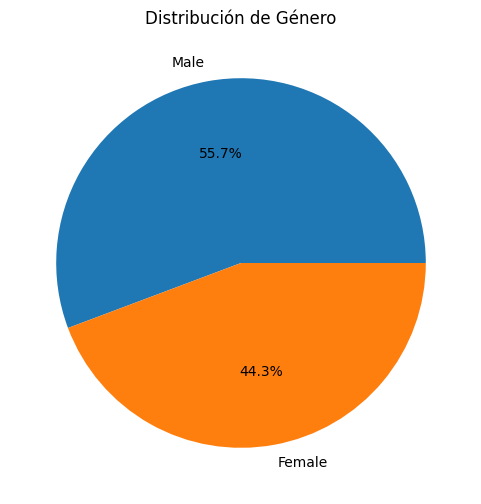

In [77]:
fig, ax = plt.subplots(figsize=(6, 6))
data['Gender'].value_counts().plot.pie(autopct='%1.1f%%', labels=['Male', 'Female'], ax=ax)
ax.set_title('Distribución de Género')
ax.set_ylabel('')  # Elimina la etiqueta del eje Y
plt.show()

### Age

In [78]:
data['Age'].value_counts().sort_index()

Age
18.0    1587
19.0    1560
20.0    2237
21.0    1723
22.0    1159
23.0    1641
24.0    2255
25.0    1781
26.0    1154
27.0    1461
28.0    2129
29.0    1947
30.0    1145
31.0    1425
32.0    1258
33.0    1892
34.0    1467
35.0      10
36.0       7
37.0       2
38.0       8
39.0       3
41.0       1
42.0       4
43.0       2
44.0       1
46.0       2
48.0       3
49.0       1
51.0       1
54.0       1
56.0       1
58.0       1
59.0       1
Name: count, dtype: int64

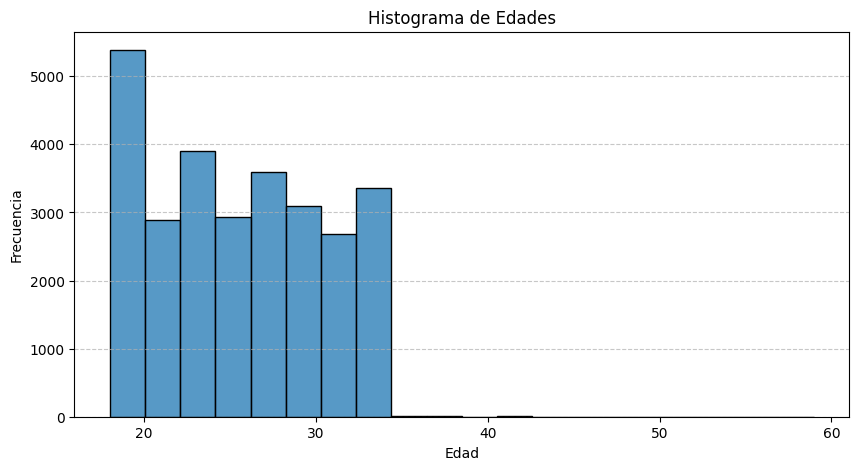

In [79]:
plt.figure(figsize=(10, 5))
sns.histplot(data['Age'], bins=20, kde=False)
plt.title('Histograma de Edades')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Text(0.5, 1.0, 'Ages $<= 34$ vs Ages $> 34$')

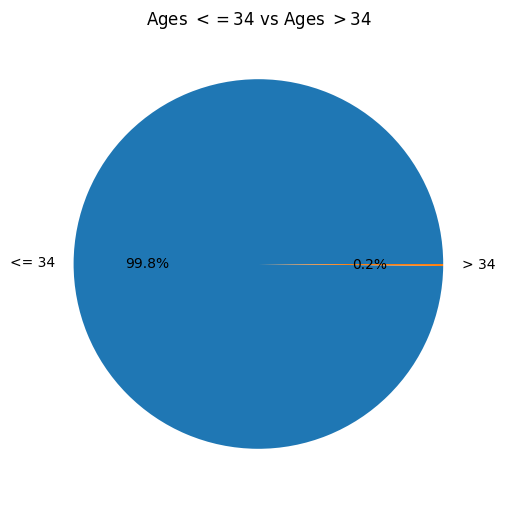

In [80]:
# pie chart representing ages <= 34 versus ages > 34
edades = [data['Age'].value_counts().sort_index().loc[18:34].sum(), data['Age'].value_counts().sort_index().loc[35:].sum()]
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(edades, labels=['<= 34', '> 34'], autopct='%1.1f%%')
ax.set_title('Ages $<= 34$ vs Ages $> 34$')

Hasta los 34 años hay una cantidad similar de registros. Mas allá de eso el dataset contiene menos de 10 datos por grupo etario, por lo que si se quiere estudiar la data por edad, habría que dejar fuera ese 0.2% de los datos.

In [81]:
data = data[data['Age'] <= 34]

(0.0, 1.0)

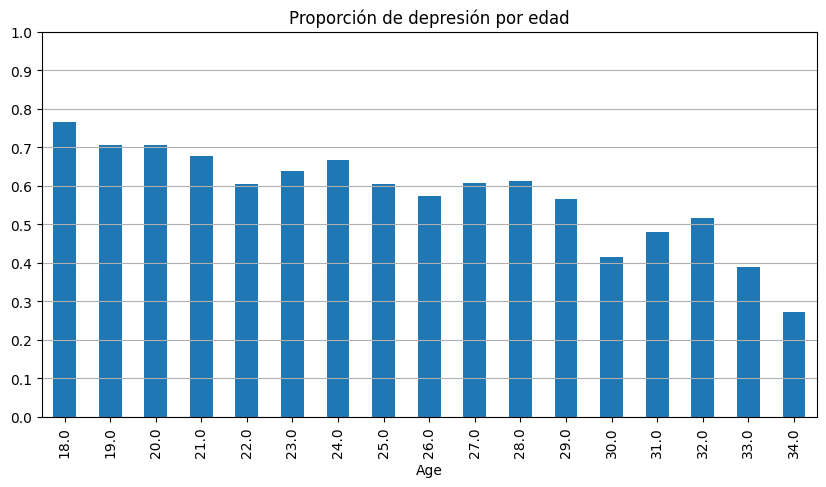

In [82]:
ax = data[data['Age'] <= 34].groupby('Age')['Depression'].mean().plot(kind='bar', figsize=(10, 5), title='Proporción de depresión por edad')
ax.grid(True, axis='y', which='major')
ax.set_yticks([i * 0.1 for i in range(11)])
ax.set_ylim(0, 1)

### Financial Stress
Se encontraron tres instancias con este atributo en valor '?'. Se quitan estas instancias del dataframe.

In [83]:
data['Financial Stress'].value_counts()

Financial Stress
5.0    6691
4.0    5754
3.0    5213
1.0    5111
2.0    5049
?         3
Name: count, dtype: int64

In [84]:
data = data[data['Financial Stress'] != '?']

### City

In [85]:
data['City'].value_counts()

City
Kalyan                  1561
Srinagar                1370
Hyderabad               1336
Vasai-Virar             1288
Lucknow                 1153
Thane                   1138
Ludhiana                1106
Agra                    1089
Surat                   1076
Kolkata                 1062
Jaipur                  1034
Patna                   1002
Pune                     967
Visakhapatnam            965
Ahmedabad                949
Bhopal                   931
Chennai                  882
Meerut                   820
Rajkot                   812
Delhi                    766
Bangalore                765
Ghaziabad                742
Mumbai                   697
Vadodara                 692
Varanasi                 683
Nagpur                   650
Indore                   643
Kanpur                   607
Nashik                   545
Faridabad                461
Saanvi                     2
Bhavna                     2
City                       2
Harsha                     2
'Less Del

Eliminamos las instancias con ciudades que tengan menos que 3 ejemplos, pues no son muestra significativa.

In [86]:
city_counts = data['City'].value_counts()
cities_to_keep = city_counts[city_counts >= 3].index
data = data[data['City'].isin(cities_to_keep)]

### Academic Pressure

In [87]:
data['Academic Pressure'].value_counts()

Academic Pressure
3.0    7429
5.0    6268
4.0    5142
1.0    4782
2.0    4164
0.0       7
Name: count, dtype: int64

Hay solo 7 instancias con valor 0, como la muestra es poco significativa, las eliminamos.

In [88]:
data = data[data['Academic Pressure'] != 0]

### CGPA

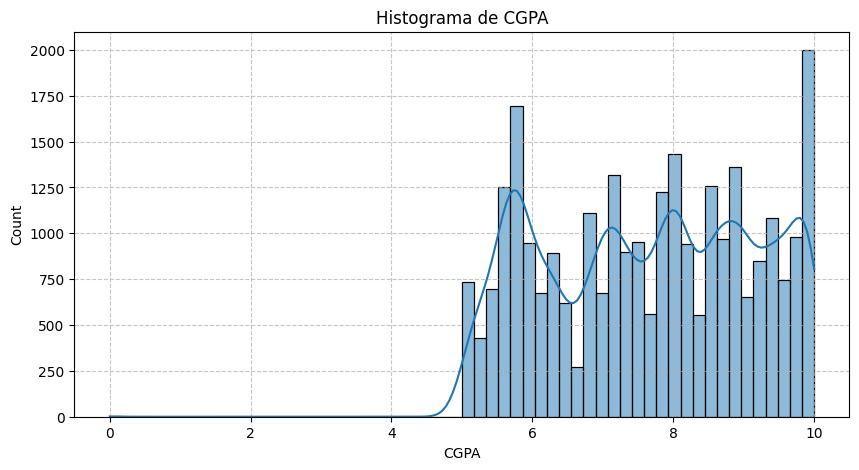

In [89]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(data[['CGPA']])

# sns.histplot(kde.sample(1_000_000))
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data['CGPA'], kde=True, ax=ax)
ax.set_title('Histograma de CGPA')
ax.grid(True, linestyle='--', alpha=0.7)

<Axes: >

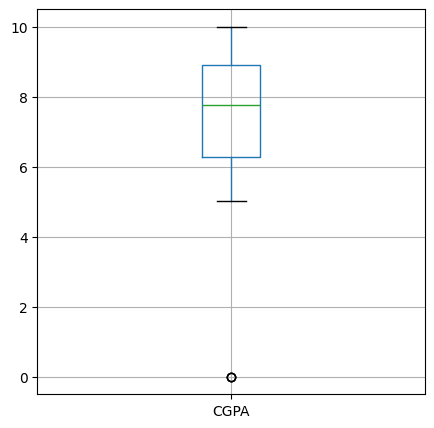

In [90]:
data.boxplot(column='CGPA',figsize=(5, 5))

### Study Satisfaction

In [91]:
data['Study Satisfaction'].value_counts()

Study Satisfaction
4.0    6338
2.0    5821
3.0    5795
1.0    5424
5.0    4404
0.0       3
Name: count, dtype: int64

Pocas instancias con Study Satisfaction 0, las eliminamos.

In [92]:
data = data[data['Study Satisfaction'] != 0]

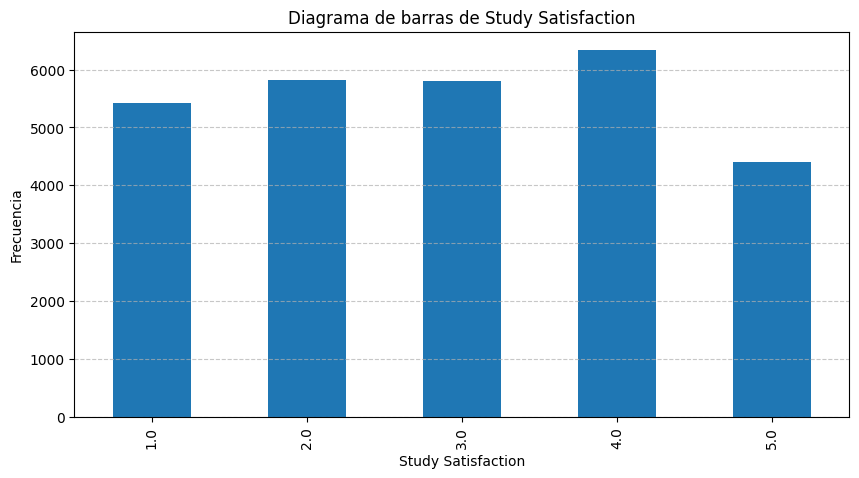

In [93]:
data['Study Satisfaction'].value_counts().sort_index().plot(kind='bar', figsize=(10, 5))
plt.title('Diagrama de barras de Study Satisfaction')
plt.xlabel('Study Satisfaction')
plt.ylabel('Frecuencia')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Sleep Durations

In [94]:
data['Sleep Duration'].value_counts()

Sleep Duration
'Less than 5 hours'    8280
'7-8 hours'            7313
'5-6 hours'            6150
'More than 8 hours'    6021
Others                   18
Name: count, dtype: int64

Un par de instancias con valor "Others", los eliminamos.

In [95]:
data = data[data['Sleep Duration'] != 'Others']

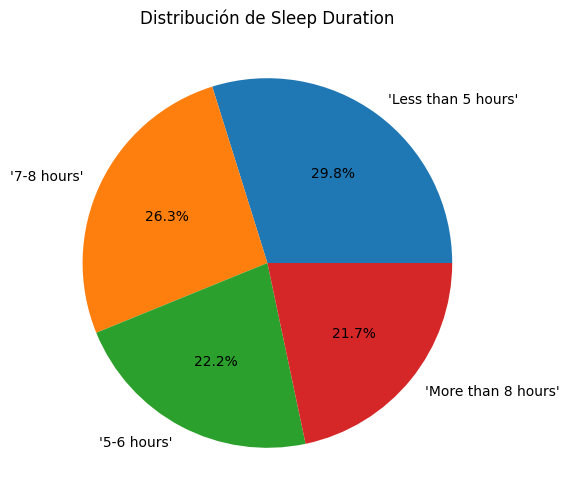

In [96]:
fig, ax = plt.subplots(figsize=(6, 6))
data['Sleep Duration'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax)
ax.set_title('Distribución de Sleep Duration')
ax.set_ylabel('')  # Elimina la etiqueta del eje Y
plt.show()

### Dietary Habits

In [97]:
data['Dietary Habits'].value_counts()

Dietary Habits
Unhealthy    10271
Moderate      9868
Healthy       7613
Others          12
Name: count, dtype: int64

12 Instancias con Others, los eliminamos

In [98]:
data = data[data['Dietary Habits'] != 'Others']

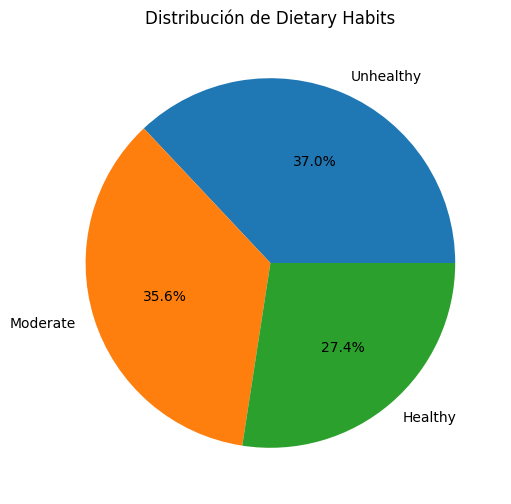

In [99]:
fig, ax = plt.subplots(figsize=(6, 6))
data['Dietary Habits'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax)
ax.set_title('Distribución de Dietary Habits')
ax.set_ylabel('')  # Elimina la etiqueta del eje Y
plt.show()

### Degree

In [100]:
data['Degree'].value_counts()

Degree
'Class 12'    6054
B.Ed          1856
B.Com         1500
B.Arch        1473
BCA           1428
MSc           1181
B.Tech        1151
MCA           1035
M.Tech        1018
BHM            920
BSc            879
M.Ed           815
B.Pharm        808
M.Com          730
BBA            695
MBBS           688
LLB            668
BE             608
BA             594
M.Pharm        579
MD             566
MBA            560
MA             542
PhD            514
LLM            480
MHM            191
ME             184
Others          35
Name: count, dtype: int64

In [101]:
data = data[data['Degree'] != 'Others']

### Have you ever...

In [102]:
data['Have you ever had suicidal thoughts ?'].value_counts()

Have you ever had suicidal thoughts ?
Yes    17548
No     10169
Name: count, dtype: int64

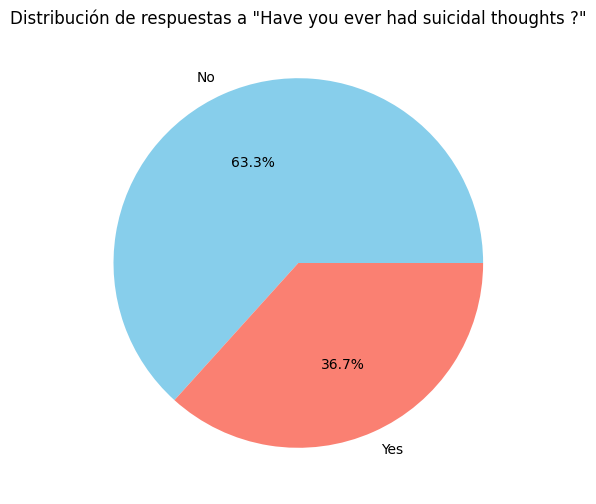

In [103]:
fig, ax = plt.subplots(figsize=(6, 6))
data['Have you ever had suicidal thoughts ?'].value_counts().plot.pie(
    autopct='%1.1f%%', labels=['No', 'Yes'], ax=ax, colors=['skyblue', 'salmon']
)
ax.set_title('Distribución de respuestas a "Have you ever had suicidal thoughts ?"')
ax.set_ylabel('')  # Elimina la etiqueta del eje Y
plt.show()

### Work/study hours

In [104]:
data['Work/Study Hours'].value_counts()

Work/Study Hours
10.0    4214
12.0    3151
11.0    2879
8.0     2499
6.0     2238
9.0     2014
7.0     1989
0.0     1686
4.0     1600
2.0     1568
3.0     1456
5.0     1283
1.0     1140
Name: count, dtype: int64

### Financial Stress

In [105]:
data['Financial Stress'].value_counts()

Financial Stress
5.0    6664
4.0    5737
3.0    5194
1.0    5086
2.0    5036
Name: count, dtype: int64

Borramos instancias con ?

In [106]:
data = data[data['Financial Stress'] != '?']

### Family History

In [107]:
data['Family History of Mental Illness'].value_counts()

Family History of Mental Illness
No     14305
Yes    13412
Name: count, dtype: int64

### Depression

In [108]:
data['Depression'].value_counts()

Depression
1    16235
0    11482
Name: count, dtype: int64

In [109]:
data.to_csv("dataset.csv", index=False)

## Exploraciones y búsqueda de patrones iniciales

Algunas variables parecen tener correlación positiva entre ellas, la idea es verificar estadísticamente si existe o no. Además, verificar otras estadísticas de los datos.


In [110]:
# Moda de cada columna
print("Moda de cada columna:")
data.mode()

Moda de cada columna:


,Gender,Age,City,Academic Pressure,CGPA,Study Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Male,24.0,Kalyan,3.0,8.04,4.0,'Less than 5 hours',Unhealthy,'Class 12',Yes,10.0,5.0,No,1


Nos interesa saber si hay correspondencia entre ideación suicida y depresión, para saber si la variable es relevante. Usamos ideación suicida como "modelo de predicción" de depresión para verificar esto:

Text(0.5, 1.0, 'Matriz de confusión entre depresión e ideación suicida')

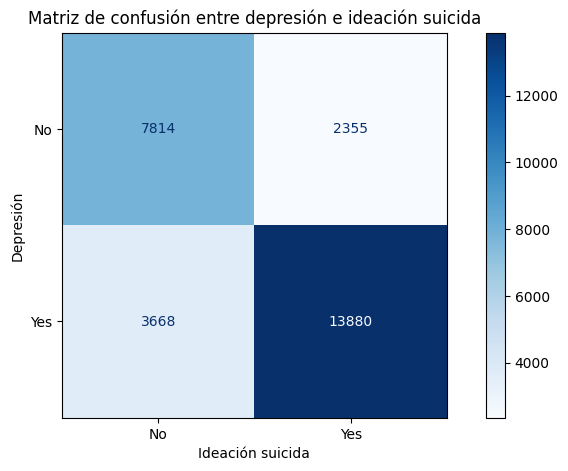

In [111]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
d = {'Yes': 1, 'No': 0}
fig, ax = plt.subplots(figsize=(10, 5))
matrix = confusion_matrix(data['Have you ever had suicidal thoughts ?'].map(d), data['Depression'])
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['No', 'Yes'])
display.plot(cmap='Blues', ax=ax)
ax.set_ylabel('Depresión')
ax.set_xlabel('Ideación suicida')
ax.set_title('Matriz de confusión entre depresión e ideación suicida')

De la misma forma, repetimos pero con los antecedentes de condiciones mentales en la familia.

Text(0.5, 1.0, 'Matriz de confusión entre depresión y antecedentes de condiciones mentales en la familia')

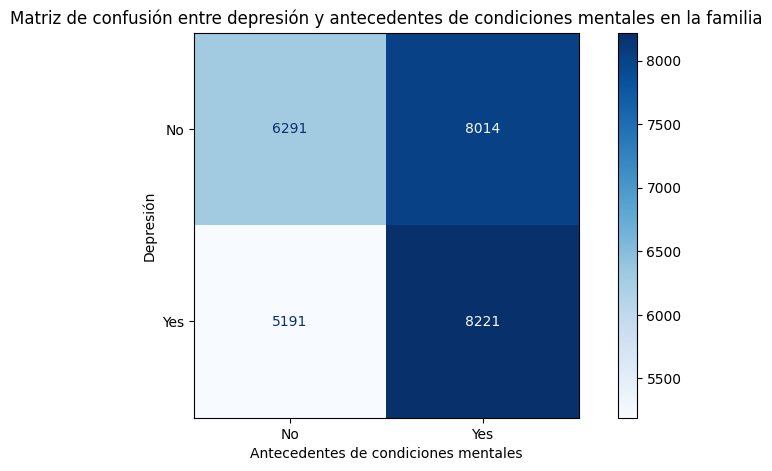

In [112]:
d = {'Yes': 1, 'No': 0}
fig, ax = plt.subplots(figsize=(10, 5))
matrix = confusion_matrix(data['Family History of Mental Illness'].map(d), data['Depression'])
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['No', 'Yes'])
display.plot(cmap='Blues', ax=ax)
ax.set_ylabel('Depresión')
ax.set_xlabel('Antecedentes de condiciones mentales')
ax.set_title('Matriz de confusión entre depresión y antecedentes de condiciones mentales en la familia')

## CGPA respecto a la label

/tmp/ipykernel_2471/1592243539.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data.groupby('Depression').boxplot(column='CGPA', ax=ax)


Text(0.5, 0.98, 'Boxplot de CGPA por presencia de depresión')

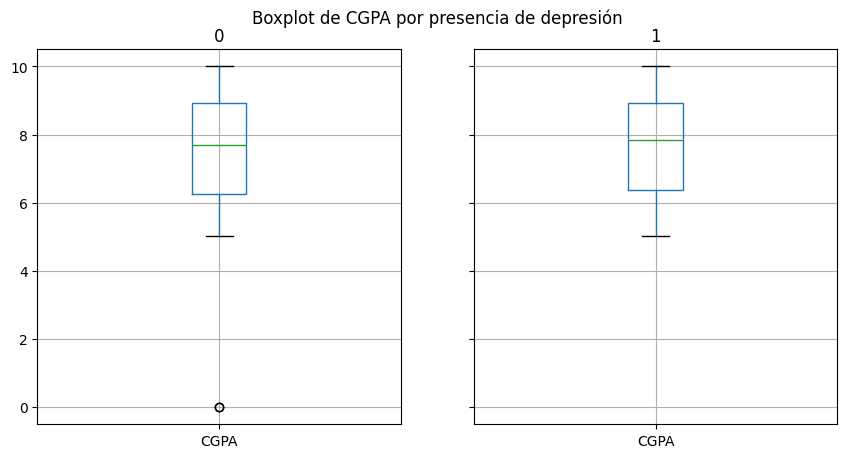

In [113]:
fig, ax = plt.subplots(figsize=(10, 5))
data.groupby('Depression').boxplot(column='CGPA', ax=ax)
fig.suptitle('Boxplot de CGPA por presencia de depresión')

# Preguntas y Problemas
Terminado el análisis exploratorio, se pueden realizar preguntas sobre los atributos y datos resultantes de ello.

- ¿Que atributos del dataset tienen mayor influencia sobre el diagnóstico de Depresión y la presencia de ideación? ¿Son atributos distintos para cada label?
- ¿Podemos identificar cualitativamente los hábitos de los estudiantes?¿Nos sirve esto para la predicción de atributos?. ¿Podemos hacer lo mismo con sus circunstancias personales?
- ¿Cuáles factores son mejores predictores del rendimiento académico de los estudiantes: las variables personales (edad, género, ciudad de residencia, estrés financiero, duración del sueño, hábitos alimenticios) o las variables académicas (presión académica, satisfacción con los estudios, horas de estudio/trabajo, tipo de carrera o grado académico)?


# Propuesta metodológica

- Pregunta 1:
    - Normalizar los datos a escala 0-1.
    - Realizar un análisis de componentes principales (PCA).
    - Concluir a partir de las ponderaciones de las primeras componentes.
    - Mediante los atributos obtenidos implementar modelos de clasificación y comparar métricas.
- Pregunta 2:
    - Seleccionar los atributos que representen cada aspecto a analizar.
    - Transformar las variables a variables numéricas.
    - Normalizar los datos.
    - Realizar clustering (k-means, DBSCAN, jerárquico).
    - Comparar los modelos usando métricas.
    - Interpretar los clusters
    - Analizar la distribución de las labels en los clusters obtenidos.
- Pregunta 3:
    - Generar dos datasets, uno por cada conjunto de atributos a estudiar.
    - Generar datasets normalizados para los modelos que lo requieran.
    - Mediante los atributos obtenidos implementar modelos de clasificación sobre CGPA y comparar métricas para cada dataset y cada modelo.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

personal_info = pd.get_dummies(data[['Age', 'Gender', 'City', 'Financial Stress', "Sleep Duration", "Dietary Habits"]], columns=['Gender', 'City', 'Financial Stress', "Sleep Duration", "Dietary Habits"])
academic_info = pd.get_dummies(data[['Academic Pressure', 'Study Satisfaction', 'Work/Study Hours']])

# """ Transformación de datos categóricos a numéricos """
# personal_info = personal_info.copy()
# for col in personal_info.columns:
#     if personal_info[col].dtype == 'object' or personal_info[col].dtype == 'string':
#         values = personal_info[col].value_counts().index
#         personal_info[col] = personal_info[col].map({v: i for i, v in enumerate(values)})

# academic_info = academic_info.copy()
# for col in academic_info.columns:
#     if academic_info[col].dtype == 'object' or academic_info[col].dtype == 'string':
#         values = academic_info[col].value_counts().index
#         academic_info[col] = academic_info[col].map({v: i for i, v in enumerate(values)})

rndf_personal_info = RandomForestRegressor(n_estimators=10)
rndf_academic_info = RandomForestRegressor(n_estimators=10)
scores = {}


X_personal = personal_info
y_personal = data['CGPA']
X_train_personal, X_test_personal, y_train_personal, y_test_personal = train_test_split(X_personal, y_personal, test_size=0.2, random_state=42)


rndf_personal_info.fit(X_train_personal, y_train_personal)
scores['personal'] = rndf_personal_info.score(X_test_personal, y_test_personal)

X_academic = academic_info
y_academic = data['CGPA']
X_train_academic, X_test_academic, y_train_academic, y_test_academic = train_test_split(X_academic, y_academic, test_size=0.2, random_state=42)
rndf_academic_info.fit(X_train_academic, y_train_academic)
scores['academic'] = rndf_academic_info.score(X_test_academic, y_test_academic)
print(f"scores: {scores}")


scores: {'personal': -0.2704332038000654, 'academic': -0.004304524926175279}


Text(0, 0.5, 'Predicciones')

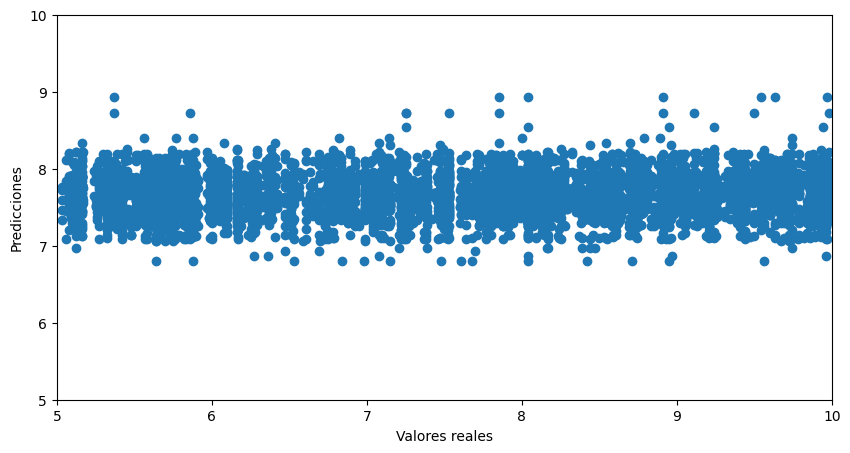

In [118]:
y_pred = rndf_academic_info.predict(X_test_academic)
plt.figure(figsize=(10, 5))
plt.ylim((5, 10))
plt.xlim((5,10))
plt.scatter(y_test_academic, y_pred)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')

Text(0, 0.5, 'Predicciones')

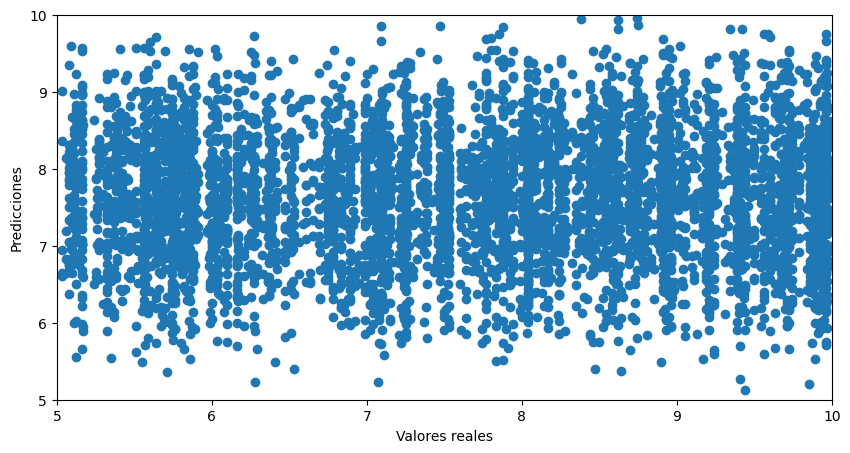

In [121]:
y_pred = rndf_personal_info.predict(X_test_personal)
plt.figure(figsize=(10, 5))
plt.ylim((5, 10))
plt.xlim((5,10))
plt.scatter(y_test_personal, y_pred)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')

Random forest vale harta callampa

In [125]:
import xgboost as xgb
from sklearn.model_selection import RepeatedKFold, cross_val_score

XGB_personal = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=10)
XGB_academic = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=10)
XGB_personal.fit(X_train_personal, y_train_personal)
XGB_academic.fit(X_train_academic, y_train_academic)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=73)
scores = {}
scores['personal'] = cross_val_score(XGB_personal, personal_info, data['CGPA'], cv=cv, n_jobs=1).mean()
scores['academic'] = cross_val_score(XGB_academic, academic_info, data['CGPA'], cv=cv, n_jobs=1).mean()
print(f"scores: {scores}")

scores: {'personal': np.float64(0.0052128963478638045), 'academic': np.float64(-0.0015034525537554948)}


Text(0, 0.5, 'Predicciones')

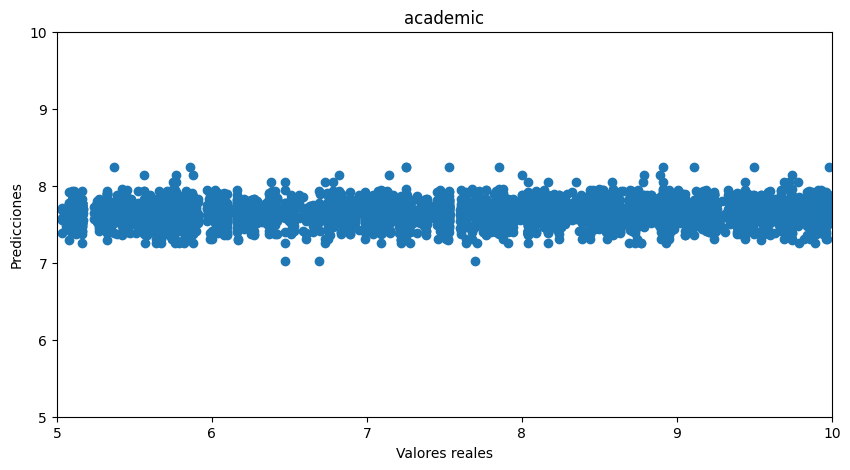

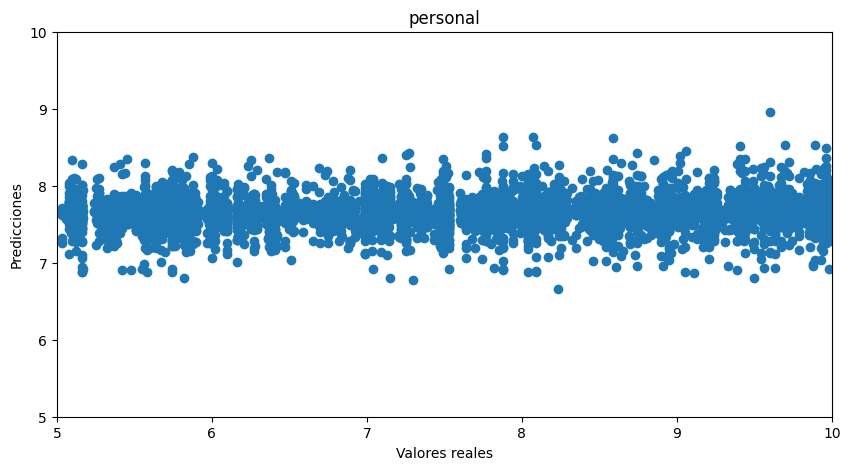

In [128]:
XGB_personal.fit(X_train_personal, y_train_personal)
XGB_academic.fit(X_train_academic, y_train_academic)
y_pred = XGB_academic.predict(X_test_academic)
plt.figure(figsize=(10, 5))
plt.ylim((5, 10))
plt.xlim((5,10))
plt.scatter(y_test_academic, y_pred)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('academic')
y_pred = XGB_personal.predict(X_test_personal)
plt.figure(figsize=(10, 5))
plt.ylim((5, 10))
plt.xlim((5,10))
plt.title('personal')
plt.scatter(y_test_personal, y_pred)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
